In [94]:
'''
    多因子选股：聚类+择时+轮动
    给出需要执行策略的时间区间以及本金，就可以自动对沪深300股票池进行kmeans聚类并且对表现较好的一类进行轮动轮动
    
    IDE: Jupyter Notebook  
    python version: python3.6
    platform: macOS High Sierra 10.13.4
    liuhuanshuo: huanshuo0801@Gmail.com
    Apr,27,2018
'''

'\n    多因子选股：聚类+择时+轮动\n    给出需要执行策略的时间区间以及本金，就可以自动对沪深300股票池进行kmeans聚类并且对表现较好的一类进行轮动轮动\n    \n    IDE: Jupyter Notebook  \n    python version: python3.6\n    platform: macOS High Sierra 10.13.4\n    liuhuanshuo: huanshuo0801@Gmail.com\n    Apr,27,2018\n'

In [95]:
from sklearn.cluster import KMeans
import pandas as pd
import time
import os
from pandas.core.frame import DataFrame
import tushare as ts
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [96]:
def riqi(begin,end):
    '''
    将输入的开始和结束时间经过筛选给出需要进行轮动的时间区间
    时间已经人工处理过，在原始文件后分别添加三列buy end select记录当天状态
    '''
    print('--------正在计算时间区间---------')
    a = pd.read_excel('/Users/liuhuanshuo/Desktop/pool_date_new.xlsx') #读取经过处理的时间文件 
    k = 0
    for i in range(327): 
        '转换时间格式'
        a.ix[k,0] = a.ix[k,0].strftime("%Y-%m-%d")
        k = k+1
    
    s = list(a['日期']).index(begin) #提取开始时间的索引
    p = list(a['日期']).index(end)   #提取结束时间的索引
    a.ix[s,2] = 'F' #修改第一天的end为FALSE 这天不卖出
    a.ix[p,3] = 'F' #修改最后一天的select为FALSE 这天不计算
    t = a[s:p+1].reset_index(drop=True) #计算begin和end之间的交易日
    t = t.fillna(0)  #对空值填充0 方便之后处理
    return t

In [97]:
def cluster(jisuanriqi):
    '''用于计算轮动时间内每最后一个交易日的聚类出的股票
       接受一个参数
       聚类的类别为9，最大迭代次数设置为500.并发数9！ 可以设置自定义！
       jisuanriqi为需要计算的整个时间区间
     '''
    print('--------正在聚类---------')
    b = ts.get_hs300s()
    vv = []
    dd = pd.DataFrame(columns = ['code','date','open','close'])
    for o in jisuanriqi['日期']:
        daima = pd.DataFrame(columns = ['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change'])
        for i in b['code']:
            try:
                s = ts.get_hist_data(i,start=o,end=o)
                s.insert(0,'code',i)
                s = s.loc[:,['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change']]
                daima = daima.append(s,ignore_index=True)
            except:
                pass
        daima.insert(1,'date',o)
        data = daima.loc[:,['ma5','ma10','v_ma10','turnover','volume','p_change']]
        k = 9 #聚类的类别
        iteration = 500 #聚类最大循环次数
        data = data
        data_zs = 1.0*(data - data.mean())/data.std() #数据标准化
        model = KMeans(n_clusters = k, n_jobs = 9, max_iter = iteration) #分为k类, 并发数9
        model.fit(data_zs) #开始聚类
        #简单打印结果
        r1 = pd.Series(model.labels_).value_counts() #统计各个类别的数目
        r2 = pd.DataFrame(model.cluster_centers_) #找出聚类中心
        r = pd.concat([r2, r1], axis = 1) #横向连接(0是纵向), 得到聚类中心对应的类别下的数目
        r.columns = list(data.columns) + [u'类别数目'] #重命名表头
        print(r)

        #详细输出原始数据及其类别
        r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)  #详细输出每个样本对应的类别
        r.columns = list(data.columns) + [u'聚类类别'] #重命名表头
        r



        tsne = TSNE()
        tsne.fit_transform(data_zs) #进行数据降维
        tsne = pd.DataFrame(tsne.embedding_, index = data_zs.index) #转换数据格式
        plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
        plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
        #不同类别用不同颜色和样式绘图
        d = tsne[r[u'聚类类别'] == 0]
        plt.plot(d[0], d[1], 'r.')
        d = tsne[r[u'聚类类别'] == 1]
        plt.plot(d[0], d[1], 'bo')
        d = tsne[r[u'聚类类别'] == 2]
        plt.plot(d[0], d[1], 'b*')
        d = tsne[r[u'聚类类别'] == 3]
        plt.plot(d[0], d[1], 'g+')
        d = tsne[r[u'聚类类别'] == 4]
        plt.plot(d[0], d[1], 'y+')
        d = tsne[r[u'聚类类别'] == 5]
        plt.plot(d[0], d[1], 'b+')
        d = tsne[r[u'聚类类别'] == 6]
        plt.plot(d[0], d[1], 'b^')
        d = tsne[r[u'聚类类别'] == 7]
        plt.plot(d[0], d[1], 'r^')
        d = tsne[r[u'聚类类别'] == 8]
        plt.plot(d[0], d[1], 'g^')
        plt.show()

        t= r.loc[:,'聚类类别']
        daima.insert(10,'聚类类别',t)
        cc = daima[(daima.聚类类别 == 7)]
        cc = cc.reset_index(drop=True)
        ee = cc.loc[:,['code','date','open','close']]
        dd = dd.append(ee,ignore_index=True)
        xx = len(ee)
        vv.append(xx)
    
    temp = dd
    return temp,vv

In [98]:
def mairuriqi(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间的购买日的股票信息
    goumaidaima为之前的到的所有要购买的代码
    '''
    print('--------正在计算所有买入日期---------')
    mairuriqi = t[t['buy'] == 'T']  #选出买入日期
    mairude = [] #空列表存放每个日期的股票长度
    y = 0
    k = 0
    temp3 = pd.DataFrame(columns = ['code','date','open','close']) #创建空数据框存放数据
    for i in mairuriqi['日期']:
        temp5 = pd.DataFrame(columns = ['code','date','open','close'])
        for file in goumaidaima[y:vv[k]].code:
            excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
            df = pd.read_csv(excel_path) 
            df_one = df.loc[:,['code','date','open','close']]    #提取指定列
            a = df_one[(df_one.date == i)]  #选择出该日期的那一行
            temp3 = temp3.append(a,ignore_index=True)
            temp5 = temp5.append(a,ignore_index=True)
        w = len(temp5)
        mairude.append(w)
        y = y + k
        k = k + 1
    print(temp3)
    return temp3,mairude

In [99]:
def maichudaima(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间需要进行卖出股票的时间信息
    '''
    print('--------正在计算所有卖出日期---------')
    mairuriqi = t[t['end'] == 'T'] 
    maichude = []
    y = 0
    k = 0
    temp2 = pd.DataFrame(columns = ['code','date','open','close'])
    for i in mairuriqi['日期']:
        temp5 = pd.DataFrame(columns = ['code','date','open','close'])
        for file in goumaidaima[y:vv[k]].code:
            excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
            df = pd.read_csv(excel_path) 
            df_one = df.loc[:,['code','date','open','close']]    #提取指定列
            a = df_one[(df_one.date == i)]  #选择特定行
            temp2 = temp2.append(a,ignore_index=True)
            temp5 = temp5.append(a,ignore_index=True)
        w = len(temp5)
        maichude.append(w)
        y = y + k
        k = k + 1
    print(temp2)
    return temp2,maichude

In [100]:
def zhengchang(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间的无需进行操作股票的时间信息
    '''
    print('--------正在计算所有无操作日期---------')
    zhengchang = t[t['buy'] == 0]
    zhengchang = zhengchang.reset_index(drop=True)
    maichu = t[t['end'] == 'T']
    maichu = maichu.reset_index(drop=True)
    zhengchangde = []
    y = 0
    k = 0
    temp4 = pd.DataFrame(columns = ['code','date','open','close'])
    for i in zhengchang['日期']:
        temp5 = pd.DataFrame(columns = ['code','date','open','close'])
        for j in maichu['日期'][k]:
            if i < j:
                for file in goumaidaima[y:vv[k]].code:
                    excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
                    df = pd.read_csv(excel_path) 
                    df_one = df.loc[:,['code','date','open','close']]    #提取指定列
                    a = df_one[(df_one.date == i)]  #选择特定行
                    temp4 = temp4.append(a,ignore_index=True)
                    temp5 = temp5.append(a,ignore_index=True)
                w = len(temp5)
                zhengchangde.append(w)
                y = y + k
                break
    print(temp4)
    return temp4,zhengchangde

In [101]:
def lundong(t,temp2,temp3,temp4,mairude,maichude,zhengchangde):
    '''
    轮动
    接受八个参数：所有交易日期，购买日期，卖出日期，无操作日期以及后面三个日期中的每个股票的长度
    在购买日期 将可用资金平均分给每个股票 以开盘价格买入
    在卖出日期 以收盘价卖出全部股票
    在无操作日期 只需根据当天收盘价更新股票价值
    
    '''
    
    keyongzijin = cash #可用资金为cash
    chigujiazhi = 0 #初始持股价值为0
    keyongzijin_1 = [] #空列表用于每次更新可用价值，下同
    chigujiazhi_1 = []
    chigushuliang = []  #创建空列表存储持股数量
    pp = 0
    kk = 0
    gg = 0
    tt = 0  #mairude里面的
    cc = 0  #maichude里面的
    zz = 0  #zhengchangde里面的
    print('--------正在轮动中，初始资金为：{0}---------'.format(keyongzijin))
    for i in range(len(t)):

        if (t.ix[i,1] == 'T' and t.ix[i,2] == 'F'):
            print('第{0}个交易日买入'.format(i))
            goumaizijin = keyongzijin/mairude[tt] #购买每只股票的资金，平均分配

            for l in range(mairude[tt]):
                chigushuliang_1 = (goumaizijin/temp3.ix[l+pp,2])
                chigushuliang.append(chigushuliang_1)

            keyongzijin = 0 #第一次卖完变成0
            chigujiazhi = goumaizijin * mairude[tt]
            pp = pp + mairude[tt]
            tt = tt + 1
            keyongzijin_1.append(keyongzijin) #将本次结果添加进储存列表
            chigujiazhi_1.append(chigujiazhi)

        elif (t.ix[i,1] == 'F' and t.ix[i,2] == 'T'):
            print('第{0}个交易日卖出'.format(i))
            chigujiazhi = 0
            chucunzijin = []
            for y in range(maichude[cc]):
                keyongzijin_2 = chigushuliang[y] * temp2.ix[y+kk,3]
                chucunzijin.append(keyongzijin_2)
            kk = kk + maichude[cc]
            cc = cc + 1
            keyongzijin = sum(chucunzijin)
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)

        elif (t.ix[i,1] == 0 and t.ix[i,2] == 0 and t.ix[i,3] == 0):
            print('第{0}个交易日，无操作'.format(i))
            xianyoujiazhi = []
            for z in range(zhengchangde[zz]):
                xianyoujiazhi_1 = chigushuliang[z] * temp4.ix[z + gg,3]
                xianyoujiazhi.append(xianyoujiazhi_1)
            gg = gg + zhengchangde[zz]
            chigujiazhi = sum(xianyoujiazhi)
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)
        '''else:
            print('ok')
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)'''

    c={"可用资金" : keyongzijin_1,
       "持股价值" : chigujiazhi_1}
    data1=DataFrame(c)
    data1.insert(0,'日期',t['日期'])
    data1['总资产'] = data1['可用资金'] + data1['持股价值'] #计算总资产
    data1 = data1.drop(len(data1)-1)
    
    return data1

In [102]:
def huitu(data):
    '''
    接受最终结果，并绘图
    '''
    import matplotlib.pyplot as plt 
    import matplotlib.font_manager as fm
    myfont = fm.FontProperties(fname = '/Library/Fonts/Arial Unicode.ttf') #设置中文字体 https://www.zhihu.com/question/25404709/answer/67672003
    %matplotlib inline
    x = data.loc[:,['日期']]
    y = data.loc[:,['总资产']]
    plt.style.use('ggplot') #使用ggplot风格
    plt.plot(x,y)
    plt.xlabel('时间',fontproperties = myfont)
    plt.ylabel('资产',fontproperties = myfont)
    plt.title('策略图',fontproperties = myfont)

In [103]:
def jisuan(begin,end):
    
    t = riqi(begin,end) #获得日期
    print(t)
    jisuanriqi = t[t['select'] == 'T'] #选择计算日期
    jisuanriqi = jisuanriqi.reset_index(drop=True)
    (goumaidaima,vv) = cluster(jisuanriqi)
    (temp3,mairude) = mairuriqi(goumaidaima,t,vv)
    (temp2,maichude) = maichudaima(goumaidaima,t,vv)
    (temp4,zhengchangde) = zhengchang(goumaidaima,t,vv)
    
    data = lundong(t,temp2,temp3,temp4,mairude,maichude,zhengchangde)
    huitu(data)
    return data


--------正在计算时间区间---------
           日期 buy end select
0  2016-04-01   F   F      T
1  2016-04-05   T   F      F
2  2016-04-06   0   0      0
3  2016-04-07   0   0      0
4  2016-04-08   F   T      T
5  2016-04-11   T   F      F
6  2016-04-12   0   0      0
7  2016-04-13   0   0      0
8  2016-04-14   0   0      0
9  2016-04-15   F   T      F
--------正在聚类---------
http://www.csindex.com.cn/uploads/file/autofile/closeweight/000300closeweight.xls


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.260025 -0.261607 -0.388209 -0.241973 -0.408350 -0.072016   117
1  4.981488  4.983091 -0.791000  2.453845 -0.699327 -0.831099     2
2 -0.541975 -0.547183  2.714555  0.249290  2.382304 -0.048327    16
3  0.806417  0.821577 -0.785908 -0.304088 -0.764410 -0.481273    47
4 -0.504186 -0.517178  0.504236  1.606976  2.147279  3.378076     8
5  1.688393  1.628930 -0.529152  5.482800 -0.330664  2.440535     4
6 -0.524029 -0.527704  0.713143 -0.224731  0.617880  0.099278    52
7  1.054140  1.075726  0.403229  1.871956 -0.024084 -1.321900     6
8  9.434572  9.390562 -0.912877 -0.626041 -0.854801 -0.536618     1


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


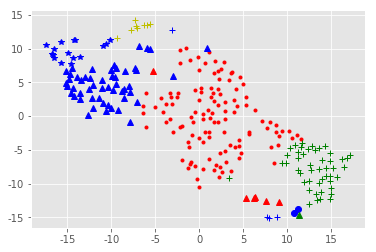

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  1.846934  1.765729 -0.424982  5.475593 -0.091883 -1.198501     4
1 -0.570204 -0.573032  0.843064 -0.373538  0.540981  0.073361    51
2  1.146360  1.154355 -0.761971 -0.001472 -0.715787  0.213854    30
3 -0.150148 -0.148496 -0.529720 -0.377292 -0.529780  0.582771    60
4 -0.427659 -0.424033  4.117596  0.166251  3.685380 -0.229962     5
5  6.462853  6.447870 -0.843593  1.225730 -0.811617 -0.884538     3
6 -0.332425 -0.336503  0.559903  1.116264  2.340137  2.845352     8
7 -0.203357 -0.205996  1.234132  1.142610  1.337469 -0.967797    15
8 -0.205808 -0.202711 -0.374357 -0.145243 -0.388341 -0.605023    74


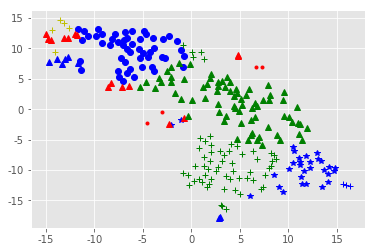

--------正在计算所有买入日期---------
      code        date   open  close
0   600570  2016-04-05  57.26  62.67
1   601198  2016-04-05  26.23  27.17
2     2074  2016-04-05  36.56  37.63
3     2292  2016-04-05  39.61  40.92
4   300033  2016-04-05  74.99  77.63
5   300059  2016-04-05  43.00  44.74
6   600570  2016-04-11  60.10  58.72
7   601198  2016-04-11  26.90  26.30
8     2074  2016-04-11  38.99  38.59
9     2292  2016-04-11  38.35  38.06
10  300033  2016-04-11  75.11  74.08
11  300059  2016-04-11  43.79  43.29
12  600074  2016-04-11  15.93  16.09
13  600688  2016-04-11   7.59   7.63
14  600871  2016-04-11   5.05   5.06
15  600958  2016-04-11  19.50  19.27
16  601099  2016-04-11   6.99   6.97
17  601198  2016-04-11  26.90  26.30
18  601377  2016-04-11   8.81   8.76
19  601608  2016-04-11   6.79   6.78
20      60  2016-04-11  10.86  11.02
--------正在计算所有卖出日期---------
      code        date   open  close
0   600570  2016-04-08  58.03  58.90
1   601198  2016-04-08  25.38  25.06
2     2074  2016-04

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for la

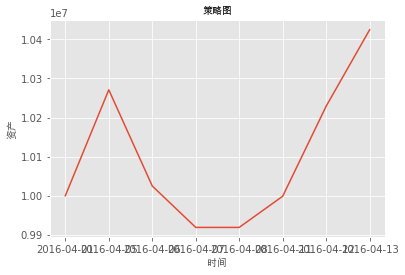

In [104]:
begin ='2016-04-01'
end = '2016-04-15'
cash = 10000000
result = jisuan(begin,end)

--------正在计算时间区间---------


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


           日期 buy end select
0  2016-04-01   F   F      T
1  2016-04-05   T   F      F
2  2016-04-06   0   0      0
3  2016-04-07   0   0      0
4  2016-04-08   F   T      T
5  2016-04-11   T   F      F
6  2016-04-12   0   0      0
7  2016-04-13   0   0      0
8  2016-04-14   0   0      0
9  2016-04-15   F   T      F
--------正在聚类---------
http://www.csindex.com.cn/uploads/file/autofile/closeweight/000300closeweight.xls
        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.287489 -0.289926 -0.436459 -0.311821 -0.435918  0.076392   100
1  6.465850  6.452248 -0.831625  1.427216 -0.751152 -0.732939     3
2  0.095618  0.103571  0.033189  0.522271 -0.154227 -1.013347    26
3 -0.719139 -0.729500  3.895620 -0.367720  4.980416  0.978915     3
4 -0.512245 -0.516545  2.268396  0.259027  1.681119 -0.278390    16
5  1.688393  1.628930 -0.529152  5.482800 -0.330664  2.440535     4
6  0.865421  0.881152 -0.773405 -0.266608 -0.759346 -0.493455    46
7 -0.538528 -0.542874  0.658639 -

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


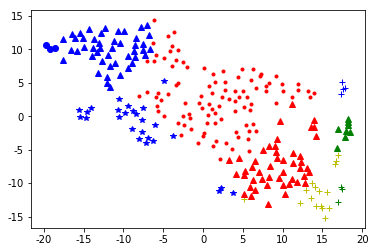

timed out
        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.177066 -0.174250 -0.490439 -0.304306 -0.501330 -0.083181   116
1  1.076518  1.086212 -0.677234  0.139152 -0.651999  0.066247    35
2  9.180289  9.322274 -0.953468 -0.641494 -0.903816 -0.379410     1
3 -0.449812 -0.458824  2.691669  0.705490  2.266076 -0.695550    14
4  1.215381  1.139523 -0.334076  5.046266 -0.202692 -0.020595     3
5  4.649954  4.555228 -0.758337  3.694087 -0.430163 -2.335474     3
6 -0.513009 -0.514999  0.650399 -0.245596  0.448268 -0.110141    66
7  0.000152 -0.003709 -0.588418  1.049694  0.044693  3.815589     5
8 -0.537083 -0.539841  1.022468  0.847663  3.177481  1.815283     7


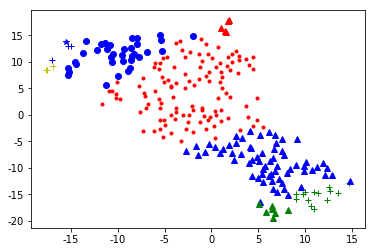

--------正在计算所有买入日期---------
      code        date   open  close
0   600010  2016-04-05   3.00   3.04
1   600016  2016-04-05   9.12   9.21
2   600018  2016-04-05   5.37   5.40
3   600019  2016-04-05   5.30   5.37
4   600029  2016-04-05   6.44   6.53
5   600048  2016-04-05   9.29   9.46
6   600111  2016-04-05  12.98  13.12
7   600115  2016-04-05   6.16   6.23
8   600170  2016-04-05   5.40   5.45
9   600208  2016-04-05   4.02   4.04
10  600221  2016-04-05   3.21   3.24
11  600352  2016-04-05  10.66  10.64
12  600369  2016-04-05   8.48   8.62
13  600415  2016-04-05   7.76   7.92
14  600489  2016-04-05  10.63  10.83
15  600705  2016-04-05  12.36  12.74
16  600795  2016-04-05   3.08   3.12
17  600837  2016-04-05  14.27  14.54
18  600886  2016-04-05   6.87   6.96
19  601006  2016-04-05   6.91   6.99
20  601111  2016-04-05   7.14   7.40
21  601166  2016-04-05  15.50  15.66
22  601169  2016-04-05   9.92  10.02
23  601390  2016-04-05   8.13   8.25
24  601398  2016-04-05   4.30   4.32
25  601555

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for la

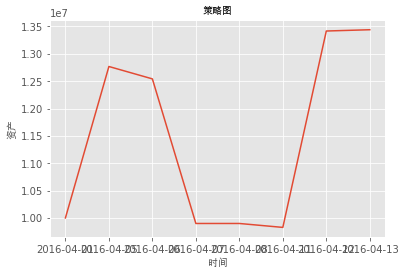

In [11]:
begin ='2016-04-01'
end = '2016-04-15'
cash = 10000000
result = jisuan(begin,end)


请输入策略开始时间：2016-04-01
请输入策略结束时间：2016-04-22
请输入策略本金：1000000
--------正在计算时间区间---------
            日期 buy end select
0   2016-04-01   F   F      T
1   2016-04-05   T   F      F
2   2016-04-06   0   0      0
3   2016-04-07   0   0      0
4   2016-04-08   F   T      T
5   2016-04-11   T   F      F
6   2016-04-12   0   0      0
7   2016-04-13   0   0      0
8   2016-04-14   0   0      0
9   2016-04-15   F   T      T
10  2016-04-18   T   F      F
11  2016-04-19   0   0      0
12  2016-04-20   0   0      0
13  2016-04-21   0   0      0
14  2016-04-22   F   T      F
--------正在聚类---------
http://www.csindex.com.cn/uploads/file/autofile/closeweight/000300closeweight.xls


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.259989 -0.263498 -0.269225  0.266481 -0.041482  1.084087    21
1  0.740833  0.755355 -0.740990 -0.207321 -0.732150 -0.534387    50
2  1.688393  1.628930 -0.529152  5.482800 -0.330664  2.440535     4
3  9.434572  9.390562 -0.912877 -0.626041 -0.854801 -0.536618     1
4 -0.530083 -0.533757  3.023890  0.149257  2.714575 -0.080397    12
5 -0.504186 -0.517178  0.504236  1.606976  2.147279  3.378076     8
6 -0.287093 -0.288704 -0.388192 -0.324005 -0.430963 -0.233348   100
7  3.296784  3.314314 -0.412980  1.923354 -0.523160 -0.862332     5
8 -0.483657 -0.486524  0.890312 -0.161508  0.684905 -0.070872    52


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


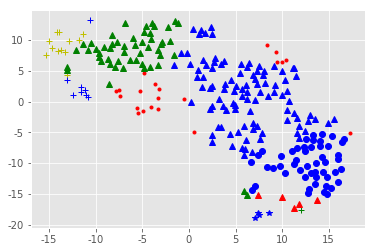

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.177066 -0.174250 -0.490439 -0.304306 -0.501330 -0.083181   116
1 -0.537083 -0.539841  1.022468  0.847663  3.177481  1.815283     7
2  6.462853  6.447870 -0.843593  1.225730 -0.811617 -0.884538     3
3 -0.302352 -0.305361  1.782175  0.819037  1.712038 -0.779158    18
4  1.082334  1.091249 -0.728780  0.104619 -0.689988  0.064447    34
5  1.846934  1.765729 -0.424982  5.475593 -0.091883 -1.198501     4
6 -0.531262 -0.533813  0.621509 -0.307823  0.382690 -0.042411    61
7  0.000152 -0.003709 -0.588418  1.049694  0.044693  3.815589     5
8 -0.713934 -0.719724  5.846899 -0.492324  3.894824 -0.133814     2


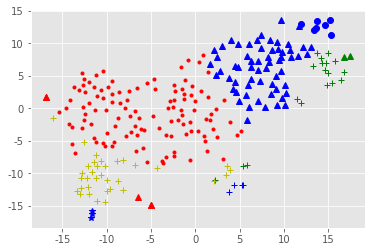

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  0.873859  0.857876 -0.804100 -0.291101 -0.723468 -0.181295    44
1 -0.570593 -0.566418  0.845101 -0.253428  0.504128 -0.384503    50
2 -0.123028 -0.137196 -0.162070  0.204972  0.152319  1.193919    25
3  6.559044  6.534594 -0.857638  0.789042 -0.788949  0.233428     3
4 -0.566991 -0.563283  1.999450  0.303982  1.788945  0.079931    16
5 -0.273718 -0.275212 -0.413716 -0.387178 -0.425837 -0.171655    96
6  0.752301  0.852798 -0.146550  2.960174 -0.072354 -0.645094    13
7  0.157674  0.077633 -0.420534  2.747615  1.130943  5.600242     4
8 -0.791684 -0.781788  5.531436  0.410526  6.929562 -1.080440     2


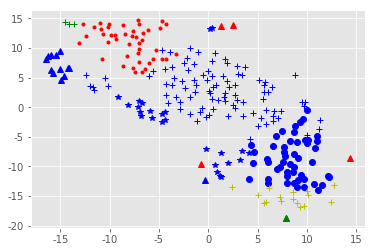

--------正在计算所有买入日期---------
      code        date    open   close
0   600570  2016-04-05   57.26   62.67
1     2153  2016-04-05   91.22   93.28
2     2466  2016-04-05  170.29  168.81
3     2558  2016-04-05  121.90  126.98
4   300033  2016-04-05   74.99   77.63
5   600570  2016-04-11   60.10   58.72
6     2153  2016-04-11  105.66  100.90
7     2466  2016-04-11  169.20  168.91
8     2558  2016-04-11  128.00  127.50
9   300033  2016-04-11   75.11   74.08
10    2153  2016-04-18   95.00   96.25
11    2466  2016-04-18  163.01  173.69
12    2558  2016-04-18  128.97  130.30
--------正在计算所有卖出日期---------
      code        date    open   close
0   600570  2016-04-08   58.03   58.90
1     2153  2016-04-08   98.00  102.90
2     2466  2016-04-08  169.00  167.00
3     2558  2016-04-08  128.98  127.00
4   300033  2016-04-08   72.88   73.33
5   600570  2016-04-15   59.95   60.16
6     2153  2016-04-15   96.55   95.59
7     2466  2016-04-15  163.00  163.34
8     2558  2016-04-15  126.40  126.30
9   3000

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for la

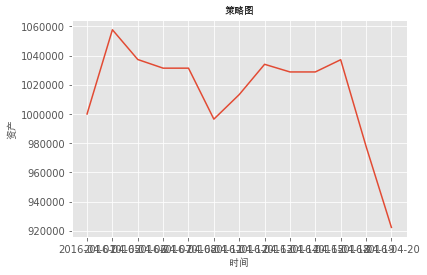

In [29]:
begin =input('请输入策略开始时间：')
end = input('请输入策略结束时间：')
cash = input('请输入策略本金：')
cash = int(cash)
result = jisuan(begin,end)

--------正在计算时间区间---------
            日期 buy end select
0   2016-04-01   F   F      T
1   2016-04-05   T   F      F
2   2016-04-06   0   0      0
3   2016-04-07   0   0      0
4   2016-04-08   F   T      T
5   2016-04-11   T   F      F
6   2016-04-12   0   0      0
7   2016-04-13   0   0      0
8   2016-04-14   0   0      0
9   2016-04-15   F   T      T
10  2016-04-18   T   F      F
11  2016-04-19   0   0      0
12  2016-04-20   0   0      0
13  2016-04-21   0   0      0
14  2016-04-22   F   T      T
15  2016-04-25   T   F      F
16  2016-04-26   0   0      0
17  2016-04-27   0   0      0
18  2016-04-28   0   0      0
19  2016-04-29   F   T      T
20  2016-05-03   T   F      F
21  2016-05-04   0   0      0
22  2016-05-05   0   0      0
23  2016-05-06   F   T      T
24  2016-05-09   T   F      F
25  2016-05-10   0   0      0
26  2016-05-11   0   0      0
27  2016-05-12   0   0      0
28  2016-05-13   F   T      T
29  2016-05-16   T   F      F
30  2016-05-17   0   0      0
31  2016-05-18

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.719139 -0.729500  3.895620 -0.367720  4.980416  0.978915     3
1 -0.274870 -0.277057 -0.389600 -0.256270 -0.406526 -0.038789   113
2 -0.521792 -0.525353  0.663983 -0.219156  0.579744  0.120545    49
3  6.465850  6.452248 -0.831625  1.427216 -0.751152 -0.732939     3
4 -0.504186 -0.517178  0.504236  1.606976  2.147279  3.378076     8
5  1.054140  1.075726  0.403229  1.871956 -0.024084 -1.321900     6
6  1.688393  1.628930 -0.529152  5.482800 -0.330664  2.440535     4
7 -0.512245 -0.516545  2.268396  0.259027  1.681119 -0.278390    16
8  0.755666  0.770854 -0.751634 -0.267540 -0.740526 -0.522795    51


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


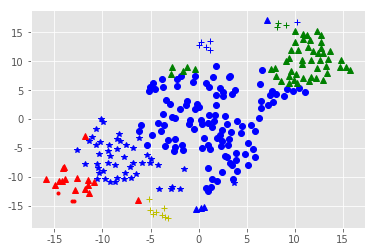

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  0.862146  0.874271 -0.811911 -0.247817 -0.769010  0.199544    39
1 -0.239152 -0.237632 -0.433665 -0.297393 -0.454949 -0.125042   112
2  3.741593  3.644348 -0.697698  6.763577  0.240546 -4.732218     1
3 -0.468431 -0.477609  2.819829  0.561458  2.375785 -0.645909    13
4  0.995717  0.977251  0.095103  2.757237  0.035273 -0.425964    11
5  6.462853  6.447870 -0.843593  1.225730 -0.811617 -0.884538     3
6  0.000152 -0.003709 -0.588418  1.049694  0.044693  3.815589     5
7 -0.526666 -0.529036  0.704142 -0.275908  0.498320 -0.086342    59
8 -0.537083 -0.539841  1.022468  0.847663  3.177481  1.815283     7


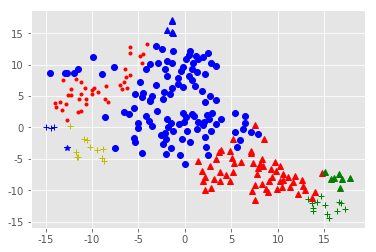

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.444338 -0.444231  0.951746  1.106153  1.610509  1.160047    11
1 -0.137485 -0.142718 -0.528632 -0.324276 -0.474907  0.066668   105
2  1.057068  1.037036 -0.809370 -0.183046 -0.724058 -0.118758    34
3  0.834340  0.942643 -0.199691  2.920376 -0.152225 -0.809501    12
4 -0.791684 -0.781788  5.531436  0.410526  6.929562 -1.080440     2
5 -0.624925 -0.619334  1.788582 -0.163024  1.188228 -0.479178    25
6  6.559044  6.534594 -0.857638  0.789042 -0.788949  0.233428     3
7  0.157674  0.077633 -0.420534  2.747615  1.130943  5.600242     4
8 -0.521580 -0.518709  0.411046 -0.298994  0.225835 -0.262628    57


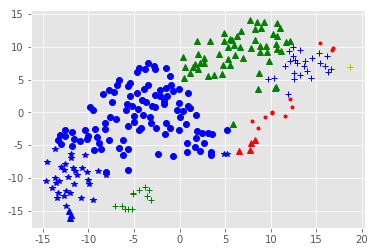

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.541951 -0.550062  1.441603 -0.036480  1.300926 -0.259615    32
1 -0.438791 -0.445450 -0.046728 -0.333512 -0.171250 -0.188233    96
2  1.628675  1.637831 -0.826310 -0.098539 -0.748745  0.101133    18
3  0.652608  0.697208 -0.156893  1.971654  0.073730  1.553470    15
4 -0.285330 -0.300119  0.324017  1.077199  0.926873 -2.521135    11
5 -0.766683 -0.776461  4.814248  0.004250  4.540384 -1.131716     4
6  7.870490  7.758869 -0.752947  2.085366 -0.563658  2.619170     2
7  0.128062  0.135986 -0.635146 -0.271926 -0.563181  0.352481    72
8  1.604991  1.524498 -0.003206  8.925142  0.501048  2.898055     1


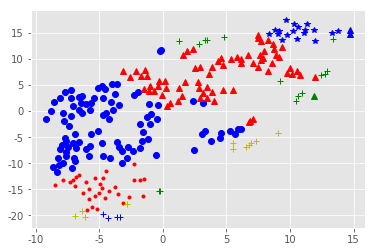

        ma5      ma10    v_ma10   turnover    volume  p_change  类别数目
0  0.220746  0.215938 -0.614188  -0.149847 -0.650065 -0.456607    59
1 -0.383415 -0.386387 -0.269354  -0.315020 -0.339397  0.037201    89
2 -0.547705 -0.551456  0.874635  -0.204329  0.797074 -0.270895    47
3  7.903397  7.900708 -0.735557   1.604275 -0.674749 -0.133042     2
4  0.520759  0.668166 -0.090233   2.859876  0.257711 -0.779866     6
5  0.085549  0.091361 -0.356425   0.744128  0.594077  2.674684    15
6  1.701003  1.693819 -0.843344   0.209971 -0.807825  0.176772    19
7  1.694414  1.651895  0.532345  10.600395  1.297771  1.518349     1
8 -0.527567 -0.532055  2.996557   0.025834  2.574334 -0.263645    14


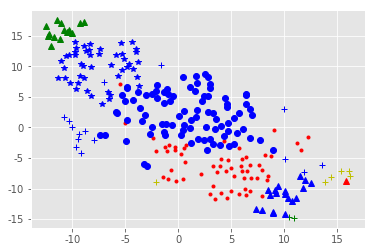

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  1.091875  1.092867 -0.784521  0.066091 -0.694689 -0.423214    33
1 -0.539232 -0.546896  0.709464 -0.367548  0.526134  0.456576    36
2  9.713892  9.711037 -0.953910 -0.626699 -0.847544  0.781865     1
3 -0.579143 -0.590728  2.296220  0.116071  2.173875  0.782982    16
4  4.117647  4.074171 -0.263623  5.602545 -0.211290  0.160093     3
5  0.219367  0.288899  0.999026  2.410727  0.874671 -2.094179    10
6 -0.259446 -0.258589 -0.282480 -0.165711 -0.253803 -0.459155   107
7 -0.065819 -0.070357 -0.455423 -0.283535 -0.413489  1.112425    47
8 -0.759506 -0.771462  6.993797 -0.037428  8.527482  1.526799     1


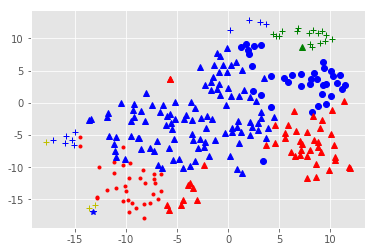

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  0.496581  0.513245 -0.665169 -0.068872 -0.626675  0.259273    51
1 -0.498089 -0.507945  4.094163  1.056112  4.174073  0.732575     6
2  9.932911  9.846381 -0.855827 -0.415290 -0.788769 -0.947388     1
3 -0.421070 -0.426137  0.515283 -0.080280  0.368516 -0.184740    52
4 -0.530314 -0.539344  1.735679 -0.154549  1.981642 -0.139255    17
5 -0.156816 -0.157200 -0.168516  0.899256  0.293396  2.919856    10
6  4.277294  4.186523  0.130614  9.119496  0.746511  1.980777     2
7  1.728632  1.744076 -0.720053  0.349869 -0.627982 -1.117513    13
8 -0.299201 -0.302139 -0.342739 -0.265892 -0.402031 -0.226501   103


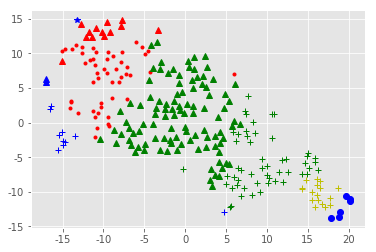

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.486955 -0.493845  0.838481 -0.146684  0.551434  0.110338    53
1  0.068798  0.074589 -0.300049  0.612584  0.284740  3.067209    11
2 -0.190251 -0.184088 -0.408618 -0.224263 -0.418428 -0.120702   144
3  7.225840  6.931367 -0.215988  4.086644 -0.015738 -3.230887     1
4  9.706280  9.841966 -0.875399 -0.354457 -0.751162  1.130641     1
5  1.126353  1.035907  0.584993  9.170835  1.666938 -2.417427     2
6 -0.403533 -0.414189  3.274831  0.441667  3.619845  0.153231    11
7  1.379280  1.382111 -0.780790 -0.094021 -0.697164 -0.052404    26
8  0.230087  0.204755  0.237606  1.105262  0.454559 -1.949255     8


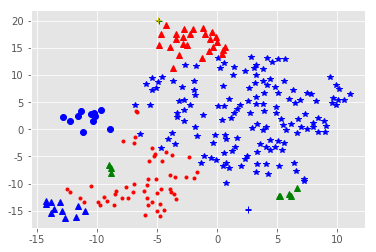

--------正在计算所有买入日期---------
       code        date   open  close
0    600030  2016-04-05  17.58  17.94
1    600109  2016-04-05  14.07  14.45
2    600871  2016-04-05   5.06   5.15
3    601018  2016-04-05   6.68   6.72
4    601099  2016-04-05   6.88   7.03
5    601288  2016-04-05   3.18   3.21
6    601328  2016-04-05   5.59   5.64
7    601377  2016-04-05   8.74   8.88
8    601668  2016-04-05   5.72   5.77
9    601901  2016-04-05   7.86   8.03
10   601939  2016-04-05   4.82   4.85
11      630  2016-04-05   2.80   2.83
12      709  2016-04-05   3.07   3.08
13      750  2016-04-05  11.67  12.18
14     2673  2016-04-05  25.80  27.11
15   300315  2016-04-05  12.13  12.49
16   600030  2016-04-11  17.70  17.41
17   600109  2016-04-11  14.22  14.09
18   600871  2016-04-11   5.05   5.06
19   601018  2016-04-11   6.41   6.46
20   601099  2016-04-11   6.99   6.97
21   601288  2016-04-11   3.15   3.17
22   601328  2016-04-11   5.52   5.56
23   601377  2016-04-11   8.81   8.76
24   601668  2016-04-1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for la

KeyError: 343

In [64]:
begin ='2016-04-01'
end = '2016-05-27'
cash = 10000000
result = jisuan(begin,end)